# Stance Detection

In [1]:
import torch
import pandas as pd
import nltk
import numpy as np
import preprocessing, feature_engineering, helpers, vis_helper
import importlib
from collections import Counter
from sklearn.metrics import confusion_matrix
import score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import time
import itertools
import utils
import importlib
import re
import json

In [2]:
importlib.reload(preprocessing)
importlib.reload(feature_engineering)
importlib.reload(helpers)
importlib.reload(utils)
preprocess = preprocessing.Preprocessing()
vis = vis_helper.Vis_Helper()

PATH = "saved_models/siamese_weighted.pt"

In [3]:
train_stances = pd.read_csv("fn_data/train_stances.csv")
train_stances = train_stances.loc[lambda x: x.Stance != "unrelated"]
print(train_stances.shape)
train_stances.head()

(13427, 3)


,Headline,Body ID,Stance
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
4,Spider burrowed through tourist's stomach and ...,1923,disagree
5,'Nasa Confirms Earth Will Experience 6 Days of...,154,agree
8,Banksy 'Arrested & Real Identity Revealed' Is ...,1739,agree
10,Gateway Pundit,2327,discuss


In [4]:
train_bodies = pd.read_csv("fn_data/train_bodies.csv")
print(train_bodies.shape)
train_bodies.head()

(1683, 2)


,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...


In [5]:
stances_tr, stances_val = preprocess.train_test_split(train_bodies, train_stances)
stances_tr.shape, stances_val.shape

((10940, 3), (2487, 3))

In [6]:
ct,ct2 = Counter(stances_val['Stance']),Counter(stances_tr['Stance'])
print(ct, ct2)
print(ct.most_common(1)[0][1]/len(list(stances_val["Stance"])))

Counter({'discuss': 1740, 'agree': 600, 'disagree': 147}) Counter({'discuss': 7169, 'agree': 3078, 'disagree': 693})
0.6996381182147166


In [7]:
glove_dict = preprocess.get_glove_dict("glove.6B.50d")

In [8]:
# [(nltk.pos_tag([x]),preprocess.get_sentiment(x)) for x in preprocess.get_clean_tokens(list(stances_tr.iloc[2,:])[0], False)]

In [9]:
# preprocess.cosine_similarity(glove_dict['reveal'], glove_dict['revealed'])

In [10]:
disagrees = stances_tr[stances_tr["Stance"]=="disagree"]
stances_tr = pd.concat([stances_tr, disagrees, disagrees]).sample(frac=1).reset_index(drop=True)

In [11]:
Counter(stances_tr['Stance'])

Counter({'disagree': 2079, 'discuss': 7169, 'agree': 3078})

In [12]:
def process_word_stance(word, glove_dict):
    #50d word vector
    if word in glove_dict:
        wv = glove_dict[word]
    else:
        wv = np.zeros((50, ))
    #4d sentiment
    sent = preprocess.get_sentiment(word)
    #16d one-hot encoding of part of speech (shortened)
    pos = nltk.pos_tag(word)[1][0]
    pos_encoding = [(1 if tag == pos else 0) for tag in preprocess.pos_short]
    #boolean flag for negating word
    stemmed_word = preprocess.stem_word(word)
    is_neg = (1 if stemmed_word in preprocess.negating_words_stemmed else 0)
    is_refuting = (1 if stemmed_word in preprocess.refuting_words_stemmed else 0)
    embedding = np.concatenate([wv, [sent["pos"], sent["neg"], sent["neu"], sent["compound"], is_neg, is_refuting], pos_encoding])
    return embedding

def process_text_stance(text, glove_dict, n_words = 20):
    tokens = preprocess.get_clean_tokens(text, False)
    if len(tokens)>=n_words:
        tokens = tokens[:n_words]
        encoding = np.array([process_word_stance(token, glove_dict) for token in tokens])
    elif len(tokens)<n_words:
        padding = [np.zeros((72,))]*(n_words-len(tokens))
        encoding = np.array([process_word_stance(token, glove_dict) for token in tokens]+padding)
    return encoding

def process_bodies_stance(df, glove_dict):
    body_info = {}
    ids = list(df["Body ID"])
    for i in range(len(ids)):
        if i % 100 == 0 and i != 0:
            print("processed "+str(i))
        body_info[ids[i]] = process_text_stance(preprocess.get_body(ids[i],df), glove_dict, 40)
    print("done! processed " + str(len(ids)))
    return body_info

def process_feats_stance(data, body_dict, glove_dict):
    headline, body_id = data[0], int(data[1])
    padding = [np.zeros((72,))]*(1)
    return np.concatenate([process_text_stance(headline, glove_dict), np.array(padding), body_dict[body_id]])

In [13]:
body_dict = process_bodies_stance(train_bodies, glove_dict)

processed 100
processed 200
processed 300
processed 400
processed 500
processed 600
processed 700
processed 800
processed 900
processed 1000
processed 1100
processed 1200
processed 1300
processed 1400
processed 1500
processed 1600
done! processed 1683


In [14]:
start = time.time()
train_feats = [process_feats_stance(i, body_dict, glove_dict) for i in stances_tr.values]
val_feats = [process_feats_stance(i, body_dict, glove_dict) for i in stances_val.values]
end = time.time()
print(int(end-start))

93


In [15]:
np.array(val_feats).shape

(2487, 61, 72)

In [16]:
def get_batch(data, targets, i,batch_size):
    batches = data[i*batch_size:i*batch_size+batch_size]
    results = targets[i*batch_size:i*batch_size+batch_size]
    results = [(2.0 if result == "agree" else (1.0 if result == "discuss" else 0.0)) for result in results]
    batches = np.array(batches)
    return np.swapaxes(batches, 0, 1), np.array(results)

In [17]:
# Test the Model
def eval_model(model):
    correct = 0
    total = 0
    batch_x_test,batch_y_test = get_batch(val_feats,[str(x[-1]) for x in stances_val.values],0,len(stances_val))
    model.eval()
    predicted = None
    with torch.no_grad():
        inputs = Variable(torch.FloatTensor(batch_x_test))
        labels = torch.LongTensor(batch_y_test)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    print('Accuracy: %d %%' % (100 * correct / total))
    return predicted

In [18]:
def score_model(predictions):    
    #use FNC scorer to generate score report
    label_prediction = [("agree" if x == 2 else ("discuss" if x == 1 else "disagree")) for x in predictions]
    label_actual = pd.DataFrame(stances_val)['Stance']
    matrix = confusion_matrix(label_actual,label_prediction)
    print('confusion matrix: \n{}\n'.format(matrix))
    score.report_score(label_actual, label_prediction)
    return matrix

In [19]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    correct = (preds == y).float() #convert into float for division 
    acc = correct.sum()/len(correct)
    return acc

In [23]:
# To do: re-implement with LSTMs for each branch
class Siamese_LSTM(nn.Module):
    # hidden dim: dimension of one RNN
    # 2 * hidden dim: concatenated outputs
    def __init__(self,embedding_dim, hidden_dim_head, hidden_dim_bod, 
                 n_layers_head, n_layers_bod, bidirectional, dropout, output_dim):
        super().__init__()
        
        # RNN dimensions [embedding_dim, hidden_dim]
        self.rnn1 = nn.LSTM(72, hidden_dim_head, num_layers=n_layers_head, bidirectional=bidirectional, dropout=dropout)
        self.rnn2 = nn.LSTM(72, hidden_dim_bod, num_layers=n_layers_bod, bidirectional=bidirectional, dropout=dropout)
        # Note: output dim could technically be higher now? cause runnign through a loss function/MLP
       
        self.dropout = nn.Dropout(dropout)
        
        self.fc1 = nn.Linear((hidden_dim_head+hidden_dim_bod)*2, (hidden_dim_head+hidden_dim_bod)) #doubled for bidirectional
        self.fc2 = nn.Linear((hidden_dim_head+hidden_dim_bod), output_dim)
        
        self.output1, self.output2 = None, None
        
    def forward(self, x):
        # x originally = [batch size, nubmer of words, embedding dim]
        # swap first two dimensions to match rnn specs
        #print(f'x shape before: ${x.shape}')
        #x = x.permute([1,0,2])
        
        """print(f'x shape: ${x.shape}')"""
        header = x[:20, :, :]
        article = x[20:60, :, :]
        
        """print(f'header shape: ${header.shape}')
        print(f'article shape: ${article.shape}')"""
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        output1, (hidden1, cell1) = self.rnn1(header)
        output2, (hidden2, cell2) = self.rnn2(article)
        
        self.output1, self.output2 = output1, output2
        """print(f'Hidden1 shape: {hidden1.shape}')
        print(f'Hidden2 shape: {hidden2.shape}')"""
        
        # Concats the last forward and backward hidden layers
        # Wouldn't you only technically want to do this if it is in fact bidirectional? 
        hidden1 = torch.cat((hidden1[-2,:,:], hidden1[-1,:,:]), dim=1)
        hidden2 = torch.cat((hidden2[-2,:,:], hidden2[-1,:,:]), dim=1)

        """print(f'Hidden1 shape front/back: {hidden1.shape}')
        print(f'Hidden2 shape front/back: {hidden2.shape}')"""
        
        hidden_merge = torch.cat((hidden1.squeeze(0), hidden2.squeeze(0)),1)
        # TODO: Check if concatenating along dim 1 might be better if first squeeze each hidden
        """print(f'Concatenated shape: {hidden_merge.shape}')"""
     
        hidden = self.dropout(hidden_merge)
        
        # Todo: add more layers beforehand, that's way too many to concatenate down to 3
        fc1 = self.fc1(hidden)
        """print(f'FC shape: {fc1.shape}')"""

        fc1 = F.relu(fc1)

        fc2 = self.fc2(fc1)
        
        return fc2

In [24]:
Counter(stances_tr['Stance'])

Counter({'disagree': 2079, 'discuss': 7169, 'agree': 3078})

In [25]:
num_epochs = 5
batch_size = 250

EMBEDDING_DIM = 72
OUTPUT_DIM = 3
DROPOUT = 0.2
N_FILTERS = 100
FILTER_SIZE = 5

HIDDEN_DIM_HEAD = 150
HIDDEN_DIM_BOD = 150

cts =(dict(Counter(stances_tr['Stance'])).values())
#reduce(lambda x1, x2: x1**(-1)+x2**(-1), cts)
s = 0 
for i in cts: 
    s += i**(-1)
weights = [i**(-1)/s for i in cts]
weights = torch.tensor([weights[2], weights[1], weights[0]])

In [26]:
model1 = RNN(EMBEDDING_DIM, 128, OUTPUT_DIM, 1, DROPOUT)
opt1 = torch.optim.Adam(model1.parameters(), lr=2e-4)
m1 = model1, opt1

model2 = RNN_LSTM(EMBEDDING_DIM, 128, OUTPUT_DIM, 1, DROPOUT)
opt2 = torch.optim.Adam(model2.parameters(), lr=2e-4)
m2 = model2, opt2

model3 = Siamese_LSTM(EMBEDDING_DIM, hidden_dim_head=HIDDEN_DIM_HEAD, hidden_dim_bod=HIDDEN_DIM_BOD, 
                dropout=DROPOUT, output_dim=OUTPUT_DIM, n_layers_head=2, n_layers_bod=2, bidirectional=True)
opt3 = torch.optim.Adam(model3.parameters(), lr=1e-4, weight_decay=1e-5)
m3 = model3, opt3

criterion = nn.CrossEntropyLoss(weight=weights)

C:\Users\linne\AppData\Local\Continuum\anaconda3\envs\cds\lib\site-packages\torch\nn\modules\rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
C:\Users\linne\AppData\Local\Continuum\anaconda3\envs\cds\lib\site-packages\torch\nn\modules\rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [27]:
queue = [m3]

In [28]:
def train(model, total_batch, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for i in range(total_batch):
        batch_x,batch_y = get_batch(train_feats, [str(x[-1]) for x in stances_tr.values],i,batch_size)
        inputs = Variable(torch.FloatTensor(batch_x))
        labels = Variable(torch.LongTensor(batch_y))
        optimizer.zero_grad()
        predictions = model(inputs)
        loss = criterion(predictions, labels)
        _, predicted = torch.max(predictions.data, 1)
        acc = binary_accuracy(predicted, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / total_batch, epoch_acc / total_batch

def evaluate(model, total_batch, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for i in range(total_batch):
            batch_x,batch_y = get_batch(val_feats, [str(x[-1]) for x in stances_val.values],i,batch_size)
            inputs = Variable(torch.FloatTensor(batch_x))
            labels = Variable(torch.LongTensor(batch_y))
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            _, predicted = torch.max(predictions.data, 1)
            acc = binary_accuracy(predicted, labels)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / total_batch, epoch_acc / total_batch

In [31]:
batches_train= int(len(train_feats)/batch_size)
batches_val = int(len(val_feats)/batch_size)

for x in queue:
    model = x[0]
    optimizer = x[1]
    print("\n")
    start = time.time()
    for epoch in range(10):
        train_loss, train_acc = train(model, batches_train, optimizer, criterion)
        valid_loss, valid_acc = evaluate(model, batches_val, criterion)

        print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')
        
    end = time.time()
    print(int(end-start))



| Epoch: 01 | Train Loss: 0.743 | Train Acc: 65.45% | Val. Loss: 0.807 | Val. Acc: 59.32% |
| Epoch: 02 | Train Loss: 0.707 | Train Acc: 67.78% | Val. Loss: 0.789 | Val. Acc: 59.72% |
| Epoch: 03 | Train Loss: 0.673 | Train Acc: 69.69% | Val. Loss: 0.793 | Val. Acc: 60.56% |
| Epoch: 04 | Train Loss: 0.647 | Train Acc: 71.02% | Val. Loss: 0.791 | Val. Acc: 60.68% |
| Epoch: 05 | Train Loss: 0.622 | Train Acc: 72.56% | Val. Loss: 0.778 | Val. Acc: 62.72% |
| Epoch: 06 | Train Loss: 0.595 | Train Acc: 73.96% | Val. Loss: 0.790 | Val. Acc: 62.56% |
| Epoch: 07 | Train Loss: 0.569 | Train Acc: 75.44% | Val. Loss: 0.796 | Val. Acc: 63.64% |
| Epoch: 08 | Train Loss: 0.547 | Train Acc: 76.73% | Val. Loss: 0.821 | Val. Acc: 63.56% |


KeyboardInterrupt: 

In [ ]:
model1 = Siamese_LSTM(EMBEDDING_DIM, hidden_dim_head=HIDDEN_DIM_HEAD, hidden_dim_bod=HIDDEN_DIM_BOD, 
                dropout=DROPOUT, output_dim=OUTPUT_DIM, n_layers_head=2, n_layers_bod=2, bidirectional=True)
model1.load_state_dict(torch.load(PATH))
model1.eval()

Accuracy: 70 %
confusion matrix: 
[[ 433   65  207]
 [  63   51   68]
 [ 306   59 1337]]

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    433    |    65     |    207    |     0     |
-------------------------------------------------------------
| disagree  |    63     |    51     |    68     |     0     |
-------------------------------------------------------------
|  discuss  |    306    |    59     |   1337    |     0     |
-------------------------------------------------------------
| unrelated |     0     |     0     |     0     |     0     |
-------------------------------------------------------------
Score: 2013.0 out of 2589.0	(77.75202780996524%)
Normalized confusion matrix
[[0.6141844  0.09219858 0.29361702]
 [0.34615385 0.28021978 0.37362637]
 [0.17978848 0.0346651  0.78554642]]


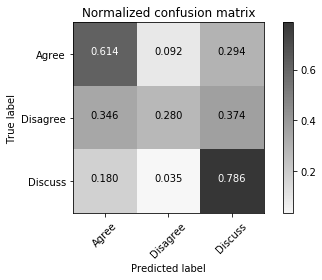

In [35]:
predicted = eval_model(model)

predicted_l = [i.item() for i in list(predicted)]
Counter(predicted_l)

matrix = score_model(predicted_l)
utils.plot_confusion_matrix(matrix, classes=["Agree","Disagree", "Discuss"],
                      title='Normalized confusion matrix')
plt.show();

In [27]:
model = model1
model.eval()
with torch.no_grad():
    batch_x,batch_y = get_batch(val_feats, [str(x[-1]) for x in stances_val.values],0,250)
    inputs = Variable(torch.FloatTensor(batch_x))
    labels = Variable(torch.LongTensor(batch_y))
    predictions = model(inputs)
    _, predicted = torch.max(predictions.data, 1)
#output = model.output.permute([1,0,2]).squeeze(0)
output1, output2 = model.output1, model.output2

In [150]:
#torch.save(model.state_dict(), PATH)

# Preliminary Heuristics

In [79]:
#np.array(predicted)[0]
for i in range(len(predicted)):
    pred = int(np.array(predicted[i]))
    actual = int(batch_y[i])
    #print(pred, actual, pred==actual)

correct_agree = np.argwhere([(np.array(predicted)[i]==2.0 and np.array(batch_y)[i]==2.0) for i in range(len(predicted))]).flatten()
correct_disagree = np.argwhere([(np.array(predicted)[i]==0.0 and np.array(batch_y)[i]==0.0) for i in range(len(predicted))]).flatten()
correct_discuss = np.argwhere([(np.array(predicted)[i]==1.0 and np.array(batch_y)[i]==1.0) for i in range(len(predicted))]).flatten()

pDisc_aAgree = np.argwhere([(np.array(predicted)[i]==1.0 and np.array(batch_y)[i]==2.0) for i in range(len(predicted))]).flatten()
pDisc_aDissagree = np.argwhere([(np.array(predicted)[i]==1.0 and np.array(batch_y)[i]==0.0) for i in range(len(predicted))]).flatten()

inc_agree = np.argwhere([(np.array(predicted)[i]!=2.0 and np.array(batch_y)[i]==2.0) for i in range(len(predicted))]).flatten()
inc_disagree = np.argwhere([(np.array(predicted)[i]!=0.0 and np.array(batch_y)[i]==0.0) for i in range(len(predicted))]).flatten()
inc_discuss = np.argwhere([(np.array(predicted)[i]!=1.0 and np.array(batch_y)[i]==1.0) for i in range(len(predicted))]).flatten()

In [30]:
def get_values(text, tokens, cell):
    j = 0 # index in tokens for duplicate token values
    num_word = 0
    body = [{} for i in range(len(text))]
        
    for i in range(len(text)):
        test = preprocess.clean(text[i])
        test = preprocess.get_tokenized_lemmas(test)
        test = preprocess.remove_stopwords(test, True)
        if(len(test)==0): 
            body[i] = {text[i]:str(0)}
            #print(text_body[i], 0)
        else:
            #token_index = np.where(tokens[j:]==test[0])
            index = list(tokens[j:]).index(test[0])
            body[i] = {text[i]:str(cell[j])}
            j+=1
    return body

In [180]:
def write_json_stance(pair, name):
    body = stances_val.iloc[pair]["Body ID"]
    text_body = preprocess.get_body(body,train_bodies)
    text_headline = stances_val.iloc[pair]["Headline"]
    
    act_cells = [{} for i in range(output1.shape[2])]
    rep_cells = [{} for i in range(4)]
    
    tokens_headline = preprocess.get_clean_tokens(text_headline, False)[:20]
    list_headline = text_headline.split(" ")
    tokens_body = preprocess.get_clean_tokens(text_body, False)[:40]
    list_body = text_body.split(" ")[:40]
    
    for i in range(output1.shape[2]):
        cell_headline = np.array(np.swapaxes(output1[:,pair,:], 0, 1)[i])
        #print(cell_headline)
        v_headline = get_values(list_headline, tokens_headline, cell_headline)

        cell_body = np.array(np.swapaxes(output2[:,pair,:], 0, 1)[i])
        v_body = get_values(list_body, tokens_body, cell_body)

        act_cells[i] = {"headline":v_headline, "body":v_body, "cell":str(i)}

    important_h = vis.get_important_cells(np.array(output1[:,pair,:]), 300)
    important_b = vis.get_important_cells(np.array(output2[:,pair,:]), 300)
    
    kmeans = KMeans(n_clusters=4).fit(np.swapaxes(output1[:,pair,:], 0, 1))
    representative_h = (kmeans.cluster_centers_)
    
    kmeans = KMeans(n_clusters=4).fit(np.swapaxes(output2[:,pair,:], 0, 1))
    representative_b = (kmeans.cluster_centers_)
    
    for i in range(len(representative_h)):
        #print(representative_h[i])
        v_headline = get_values(list_headline, tokens_headline, representative_h[i])
        
        v_body = get_values(list_body, tokens_body, representative_b[i])

        rep_cells[i] = {"headline":(v_headline), "body":v_body, "cell":str(i)}

    text = ""
    for i in text_body.split(" ")[40:]:
        text += i + " "

    cells_json = {
        "activations": act_cells,
        "important_h":important_h,
        "important_b":important_b, 
        "remain_b":text,
        "representative":rep_cells
    }
    with open('Vis/activations_Siamese_'+name+'.json', 'w') as outfile:
        json.dump(cells_json, outfile)

In [181]:
titles = [
    {"name":"incDiscuss", "val":inc_discuss},
    {"name":"incAgree", "val":inc_agree},
    {"name":"incDisagree", "val":inc_disagree},
    {"name":"correctAgree", "val":correct_agree},
    {"name":"correctDisagree", "val":correct_disagree},
    {"name":"correctDiscuss", "val":correct_discuss},
    {"name":"pDisc-aAgree", "val":pDisc_aAgree},
    {"name":"pDisc-aDisagree", "val":pDisc_aDissagree}
]

for i in titles:
    print(i["val"], i["name"])
    write_json_stance(i["val"][0], i["name"])
"""pair=inc_discuss[0]
name = "incDiscuss"
write_json_stance(pair, name)"""

[  8  13  17  22  29  56  62  64  67  93  97 126 145 147 155 158 163 183
 184 187 209 211 234 246 247] incDiscuss
[  0   4  16  26  83 109 118 131 186 196 200 237 239] incAgree
[ 12  59  66 188 199 213 219 228] incDisagree
[  2   3   5   6   9  15  19  30  32  34  36  37  45  48  49  52  55  58
  65  73  98 107 112 113 122 127 137 140 142 148 157 164 165 170 172 174
 178 189 197 201 207 218 223 225 227 233] correctAgree
[  1  25  80 102 110 128 135 146 193 210 231] correctDisagree
[  7  10  11  14  18  20  21  23  24  27  28  31  33  35  38  39  40  41
  42  43  44  46  47  50  51  53  54  57  60  61  63  68  69  70  71  72
  74  75  76  77  78  79  81  82  84  85  86  87  88  89  90  91  92  94
  95  96  99 100 101 103 104 105 106 108 111 114 115 116 117 119 120 121
 123 124 125 129 130 132 133 134 136 138 139 141 143 144 149 150 151 152
 153 154 156 159 160 161 162 166 167 168 169 171 173 175 176 177 179 180
 181 182 185 190 191 192 194 195 198 202 203 204 205 206 208 212 214 215
 21

'pair=inc_discuss[0]\nname = "incDiscuss"\nwrite_json_stance(pair, name)'

In [33]:
output2[:,1,:].shape

torch.Size([40, 300])

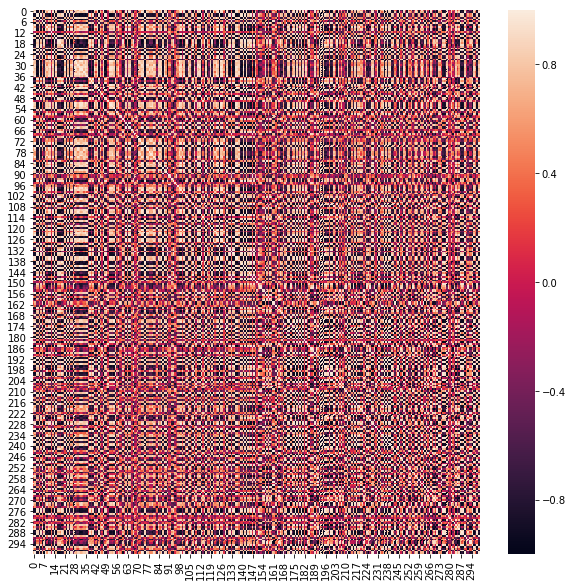

In [182]:
# Observation: for Siamese networks the "grid" pic goes away with more trainign. Maybe try increasing more? 
output1_cov = np.corrcoef(np.array(output1[:,3,:]), rowvar=False)

plt.figure(figsize=(10,10))
ax = sns.heatmap(output1_cov.T)
plt.show()

In [ ]:
# Siamese network: look at the similarity in headline/body output vectors for
print(output1[:,0,:].shape, output2[:,0,:].shape)

In [ ]:
important_h = vis.get_important_cells(np.array(output1[:,0,:]), 300)
important_b = vis.get_important_cells(np.array(output2[:,0,:]), 300)
print(important1["top5_mag"], important2["top5_mag"])

text = ""
for i in text_body.split(" ")[40:]:
    text += i + " "

In [ ]:
a = np.array(output1[:,0,210])
b = np.array(output2[:,0,210])
print(output1.shape, output2.shape)

In [ ]:
norms = []
# Find all the words with similar "representations", being the activations for every cell at that time step
for i in range((output1.shape[0])): 
    for j in range((output2.shape[0])):
        dot = np.dot(np.array(output1[i, 0, :]),np.array(output2[j, 0, :]))
        norm = np.linalg.norm(np.array(output1[i, 0, :]))*np.linalg.norm(np.array(output2[j, 0, :]))
        norms.append(dot/norm)
        #print(dot/norm)
norms = np.array(norms)
print(scipy.stats.describe(norms))

In [ ]:
norms_abs = np.absolute(norms)
print(norms_abs.max(), norms_abs.argmax())
print("output1: ",norms_abs.argmax()//40,"\n","output2: ", norms_abs.argmax()%40)

print(norms_abs.min(), norms_abs.argmin())
print("output1: ",norms_abs.argmin()//40,"\noutput2: ", norms_abs.argmin()%40)

In [ ]:
plt.plot(np.array(output1[0, 0, :]))
plt.plot(np.array(output2[39, 0, :]), linewidth=1)

In [ ]:
plt.plot(norms_abs)

In [ ]:
np.argsort(norms_abs)[:21] # bottom 20
np.argsort(norms_abs)[-20:]

In [ ]:
pts = [norms_abs[i] for i in range(0, 800, 20)]

# Representative Clusters

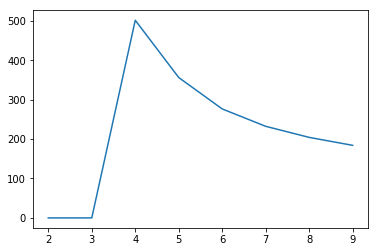

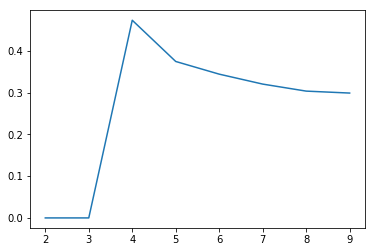

In [149]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

cells1 = np.swapaxes(output1[:,5,:], 0, 1)
var = np.zeros(10)
sils =np.zeros(10)

for j in range(output1.shape[1]):
    for i in range(2, 10):  
        kmeans = KMeans(n_clusters=i, random_state=0).fit(np.swapaxes(output2[:,j,:], 0, 1))
        var[i] += kmeans.inertia_
        sils[i] += silhouette_score(np.swapaxes(output2[:,j,:], 0, 1), kmeans.labels_)

sils = sils[:8]
var = var[:8]
plt.plot([i for i in range(2, 10)], var/output1.shape[1])
plt.show()
plt.plot([i for i in range(2, 10)], sils/output1.shape[1])
plt.show()

In [157]:
str(kmeans.cluster_centers_[0])

'[ 0.0045009   0.00831639  0.0024506   0.00479659  0.00428424  0.00282318\n -0.00029575  0.00489973  0.01566319  0.02514289  0.03440941  0.04335545\n  0.05184763  0.05973143  0.0668362   0.07297385  0.07792823  0.08143415\n  0.08314685  0.08260669]'

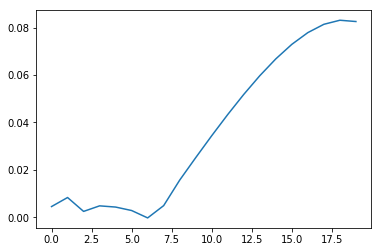

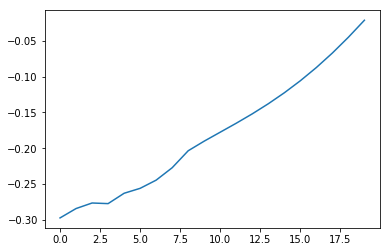

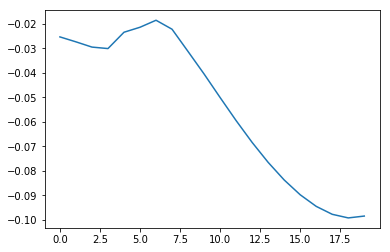

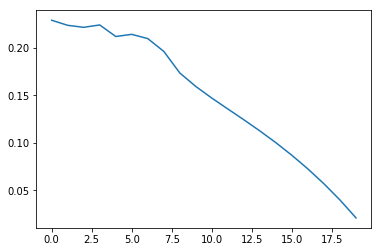

In [155]:
n=4
kmeans = KMeans(n_clusters=n).fit(np.swapaxes(output1[:,2,:], 0, 1))
for i in range(n):
    plt.plot(kmeans.cluster_centers_[i])
    plt.show()